#频繁模式与关联规则挖掘
##1 对数据集进行处理，转换成适合进行关联规则挖掘的形式
选取Wine Reviews数据集，该数据集包含葡萄酒的名称、描述、产地等信息。数据集中存在缺失值，对于存在缺失值的属性，使用该属性中频率最高的值进行填补。 该数据集中共有10个属性，首先确定每个属性的频率最高的值。读取数据集，遍历数据集的每个属性，根据属性的值的频数进行排序，最大频数即为最大频率，在遍历过程中，如果频数最高的值为缺失值，那么取下一个频数最高的值。最终将10个属性的最高频率的值存储在列表中。 接下来将每个属性的缺失值替换为该属性频率最高的值
在此分析产地、品种的关系。

In [13]:
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import pylab
from collections import defaultdict
import itertools

# 用最高频率值来填补缺失值
def na_max(path):
    wine_data = pd.read_csv(path, header=0, index_col=0, engine='python', encoding='utf-8')
    wine_data = wine_data.values
    max_time = []  # 每个属性最大频数的值
    # 确定每个属性最大频数的值
    for cl in range(wine_data.shape[1]):
        counter = Counter(wine_data[:, cl])
        counter = counter.most_common()  # 排序，返回类型为list，list的每个元素为内容和频数
        if counter[0][0] == counter[0][0]:  # 如果最大频数不为空值
            max_time.append(counter[0][0])
        else:  # 如果最大频数为空值
            max_time.append(counter[1][0])

    # 对每个属性的空值进行替换
    wine_max = pd.DataFrame(wine_data)
    for cl in range(wine_data.shape[1]):
        wine_max[cl] = wine_max[cl].fillna(max_time[cl])
       

    return wine_max



df = pd.read_csv('C:/Users/xue/Desktop/课程_研一下/数据挖掘/课后作业/7/wine-reviews/winemag-data-130k-fill.csv', index_col=0,
                 engine='python', encoding='utf-8')
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,20.0,Sicily & Sardinia,Etna,Central Coast,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,Napa Valley,Central Coast,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",Reserve,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Central Coast,Alexander Peartree,@vossroger,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [17]:
transactions = []
df = pd.read_csv('C:/Users/xue/Desktop/课程_研一下/数据挖掘/课后作业/7/wine-reviews/winemag-data-130k-fill.csv', index_col=0,
                 engine='python', encoding='utf-8')
for index, row in df.iterrows():
    transactions += [(row['country'], row['variety'], row['winery'])]
transactions[:20]

[('Italy', 'White Blend', 'Nicosia'),
 ('Portugal', 'Portuguese Red', 'Quinta dos Avidagos'),
 ('US', 'Pinot Gris', 'Rainstorm'),
 ('US', 'Riesling', 'St. Julian'),
 ('US', 'Pinot Noir', 'Sweet Cheeks'),
 ('Spain', 'Tempranillo-Merlot', 'Tandem'),
 ('Italy', 'Frappato', 'Terre di Giurfo'),
 ('France', 'Gewürztraminer', 'Trimbach'),
 ('Germany', 'Gewürztraminer', 'Heinz Eifel'),
 ('France', 'Pinot Gris', 'Jean-Baptiste Adam'),
 ('US', 'Cabernet Sauvignon', 'Kirkland Signature'),
 ('France', 'Gewürztraminer', 'Leon Beyer'),
 ('US', 'Cabernet Sauvignon', 'Louis M. Martini'),
 ('Italy', 'Nerello Mascalese', 'Masseria Setteporte'),
 ('US', 'Chardonnay', 'Mirassou'),
 ('Germany', 'Riesling', 'Richard Böcking'),
 ('Argentina', 'Malbec', 'Felix Lavaque'),
 ('Argentina', 'Malbec', 'Gaucho Andino'),
 ('Spain', 'Tempranillo Blend', 'Pradorey'),
 ('US', 'Meritage', 'Quiévremont')]

##2 找出频繁模式
使用Aapriori算法，频繁项集（support>0.03, confidence>0.1, lift>1）。

In [18]:
def apriori(transactions, support=0.1, confidence=0.8, lift=1, minlen=2, maxlen=2):
    item_2_tranidxs = defaultdict(list)
    itemset_2_tranidxs = defaultdict(list)

    for tranidx, tran in enumerate(transactions):
        for item in tran:
            item_2_tranidxs[item].append(tranidx)
            itemset_2_tranidxs[frozenset([item])].append(tranidx)

    item_2_tranidxs = dict([(k, frozenset(v)) for k, v in item_2_tranidxs.items()])
    itemset_2_tranidxs = dict([
        (k, frozenset(v)) for k, v in itemset_2_tranidxs.items()])

    tran_count = float(len(transactions))
    # print('Extracting rules in {} transactions...'.format(int(tran_count)))

    valid_items = set(item
                      for item, tranidxs in item_2_tranidxs.items()
                      if (len(tranidxs) / tran_count >= support))

    pivot_itemsets = [frozenset([item]) for item in valid_items]
    freqsets = []

    if minlen == 1:
        freqsets.extend(pivot_itemsets)

    for i in range(maxlen - 1):
        new_itemset_size = i + 2
        new_itemsets = []

        for pivot_itemset in pivot_itemsets:
            pivot_tranidxs = itemset_2_tranidxs[pivot_itemset]
            for item, tranidxs in item_2_tranidxs.items():
                if item not in pivot_itemset:
                    common_tranidxs = pivot_tranidxs & tranidxs
                    if len(common_tranidxs) / tran_count >= support:
                        new_itemset = frozenset(pivot_itemset | set([item]))
                        if new_itemset not in itemset_2_tranidxs:
                            new_itemsets.append(new_itemset)
                            itemset_2_tranidxs[new_itemset] = common_tranidxs

        if new_itemset_size > minlen - 1:
            freqsets.extend(new_itemsets)

        pivot_itemsets = new_itemsets

    # print('{} frequent patterns found'.format(len(freqsets)))

    for freqset in freqsets:
        for item in freqset:
            rhs = frozenset([item])
            lhs = freqset - rhs
            support_rhs = len(itemset_2_tranidxs[rhs]) / tran_count
            if len(lhs) == 0:
                lift_rhs = float(1)
                if support_rhs >= support and support_rhs > confidence and lift_rhs > lift:
                    yield (lhs, rhs, support_rhs, support_rhs, lift_rhs)
            else:
                confidence_lhs_rhs = len(itemset_2_tranidxs[freqset]) \
                                     / float(len(itemset_2_tranidxs[lhs]))
                lift_lhs_rhs = confidence_lhs_rhs / support_rhs

                if confidence_lhs_rhs >= confidence and lift_lhs_rhs > lift:
                    support_lhs_rhs = len(itemset_2_tranidxs[freqset]) / tran_count
                    yield (lhs, rhs, support_lhs_rhs, confidence_lhs_rhs, lift_lhs_rhs)


rules = apriori(transactions, support=0.03, confidence=0.1, lift=1)
rules_sorted = sorted(rules, key=lambda x: (x[4], x[3], x[2]),
                      reverse=True)  # ORDER BY lift DESC, confidence DESC, support DESC

for r in rules_sorted:
    print(r)

(frozenset({'Bordeaux-style Red Blend'}), frozenset({'France'}), 0.03635426364342815, 0.6832971800433839, 4.019771773295553)
(frozenset({'France'}), frozenset({'Bordeaux-style Red Blend'}), 0.03635426364342815, 0.2138686461775223, 4.019771773295553)
(frozenset({'US'}), frozenset({'Cabernet Sauvignon'}), 0.05629717398496588, 0.13409203364670955, 1.839957316838734)
(frozenset({'Cabernet Sauvignon'}), frozenset({'US'}), 0.05629717398496588, 0.772487331081081, 1.8399573168387335)
(frozenset({'US'}), frozenset({'Pinot Noir'}), 0.0760785098214217, 0.18120842267304416, 1.7744172307118378)
(frozenset({'Pinot Noir'}), frozenset({'US'}), 0.0760785098214217, 0.7449709937467038, 1.7744172307118375)
(frozenset({'US'}), frozenset({'Chardonnay'}), 0.052350139646536537, 0.12469074715487383, 1.3788973962789166)
(frozenset({'Chardonnay'}), frozenset({'US'}), 0.052350139646536537, 0.5789160214413341, 1.3788973962789164)


##3 导出关联规则，计算其支持度和置信度

In [19]:
import csv 

with open('result.csv', 'wt') as f:
    f_csv = csv.writer(f, delimiter=',')
    f_csv.writerow(['rule', 'sup', 'conf', 'lift'])
    for r in rules_sorted:
        f_csv.writerow([f'{str(list(r[0])[0])} => {str(list(r[1])[0])}', r[2], r[3], r[4]])

pd.read_csv('result.csv')

,rule,sup,conf,lift
0,Bordeaux-style Red Blend => France,0.036354,0.683297,4.019772
1,France => Bordeaux-style Red Blend,0.036354,0.213869,4.019772
2,US => Cabernet Sauvignon,0.056297,0.134092,1.839957
3,Cabernet Sauvignon => US,0.056297,0.772487,1.839957
4,US => Pinot Noir,0.076079,0.181208,1.774417
5,Pinot Noir => US,0.076079,0.744971,1.774417
6,US => Chardonnay,0.052350,0.124691,1.378897
7,Chardonnay => US,0.052350,0.578916,1.378897


##4 对规则进行评价，使用Lift， Kulc指标
Lift指标的结果如第三部分所示。
在此计算Kulc

In [21]:
res = []
for r in rules_sorted:
    conf1 = r[3]
    for r2 in rules_sorted:
        if r2[0] == r[1] and r2[1] == r[0]:
            conf2 = r2[3]
    kulc = (conf1 + conf2) / 2
    res.append(kulc)

res

[0.4485829131104531,
 0.4485829131104531,
 0.4532896823638953,
 0.4532896823638953,
 0.463089708209874,
 0.463089708209874,
 0.351803384298104,
 0.351803384298104]

##5 对挖掘结果进行分析和可视化展示
这里以Bordeaux-style Red Blend => France为例。
Bordeaux-style Red Blend这个品种的葡萄酒基本上产自法国，以此来检验：

In [22]:
df[df['variety'] == 'Bordeaux-style Red Blend'].sample(20)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
62183,France,This wine has an austere character that comes ...,Reserve,86,30.0,Bordeaux,Margaux,Central Coast,Roger Voss,@vossroger,Château Siran 2013 Margaux,Bordeaux-style Red Blend,Château Siran
113509,France,Wood spice aromas are an indication this wine ...,Reserve,90,22.0,Bordeaux,Blaye Côtes de Bordeaux,Central Coast,Roger Voss,@vossroger,Château Barbé 2015 Blaye Côtes de Bordeaux,Bordeaux-style Red Blend,Château Barbé
102938,France,"Warm and ripe, this is a delicious, structured...",Alios,91,14.0,Bordeaux,Cadillac Côtes de Bordeaux,Central Coast,Roger Voss,@vossroger,Château Sainte-Marie 2014 Alios (Cadillac Côt...,Bordeaux-style Red Blend,Château Sainte-Marie
5860,France,The Baylet family has produced a rich wine in ...,Reserve,88,18.0,Bordeaux,Bordeaux Supérieur,Central Coast,Roger Voss,@vossroger,Château Landereau 2015 Bordeaux Supérieur,Bordeaux-style Red Blend,Château Landereau
94758,US,Despite coming from declassified barrels from ...,Coda,92,25.0,Washington,Red Mountain,Columbia Valley,Sean P. Sullivan,@wawinereport,Cadence 2012 Coda Red (Red Mountain),Bordeaux-style Red Blend,Cadence
15996,France,"Still very firm, this wine shows the tannic st...",Reserve,86,30.0,Bordeaux,Saint-Émilion,Central Coast,Roger Voss,@vossroger,Château Tour Grand Faurie 2011 Saint-Émilion,Bordeaux-style Red Blend,Château Tour Grand Faurie
33543,US,This very limited reserve mixes old-vine fruit...,Sagemoor Vineyards Reserve,92,50.0,Washington,Columbia Valley (WA),Columbia Valley,Paul Gregutt,@paulgwine,Tamarack Cellars 2007 Sagemoor Vineyards Reser...,Bordeaux-style Red Blend,Tamarack Cellars
5716,France,The estate is under the same ownership as Chât...,Reserve,91,20.0,Bordeaux,Haut-Médoc,Central Coast,Roger Voss,@vossroger,Château Clément-Pichon 2010 Haut-Médoc,Bordeaux-style Red Blend,Château Clément-Pichon
90979,France,"92-94 Barrel sample. A serious, but elegant wi...",Barrel sample,93,20.0,Bordeaux,Saint-Émilion,Central Coast,Roger Voss,@vossroger,Château Trottevieille 2008 Barrel sample (Sai...,Bordeaux-style Red Blend,Château Trottevieille
14726,Brazil,Bell pepper and sharp red fruit aromas provide...,Proprietary Red,82,10.0,Serra Gaúcha,Napa Valley,Central Coast,Michael Schachner,@wineschach,Aurora Cellars 2004 Proprietary Red Red (Serra...,Bordeaux-style Red Blend,Aurora Cellars


由结果可以看出，法国的确较多。
绘制直方图，从直方图中可以看到，相当多的部分是法国的。

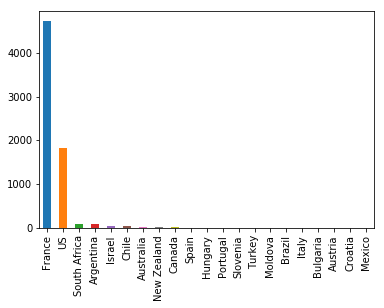

In [23]:
df[df['variety'] == 'Bordeaux-style Red Blend']['country'].value_counts().plot(kind='bar')